In [173]:
from datetime import date
today = date.today()

In [174]:
#stock = ['SPY', 'GLD', 'SPLB', 'EEM', 'QQQ', 'SLV', 'HYG', 'VWO', 'TLT', 'FXI']
stock = ['SPY']
sampling = ['daily', 'weekly'][0]
aggregation = ['last_day', 'mean'][0]
#stock = ['VTI', 'VEU', 'VNQ', 'BND', 'GSG']
date_start = '1993-01-01'
date_end = today.strftime("%Y-%m-%d")

In [175]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas_datareader as pdr
import statsmodels.api as sm
import scipy.stats as scs

In [176]:
combined_data = []
for i in range(len(stock)):
    df = pdr.DataReader(stock[i], 
                       start=date_start, 
                       end=date_end, 
                       data_source='yahoo')
    name = stock[i]
    df_stock = df[['Adj Close']]
    df_stock = df_stock.rename(columns={"Adj Close" : name})
    if i > 0:
        combined_data = pd.concat([combined_data, df_stock], axis = 1)
    else:
        combined_data = df_stock
        
    
    #combined_data.append(df_stock)
    #combined_data.append(df_stock)
    #combined_data = pd.concat([combined_data, df_stock], axis=1, join="inner" )
    #df1.append(df4, ignore_index=True, sort=False)
    #result = pd.concat([df1, df4], axis=1, join="inner")
if sampling == 'weekly':
    if aggregation == 'last_day':
        combined_data = combined_data.resample('W').agg('last')
    elif aggregation == "mean":
        combined_data = combined_data.resample('W').agg('mean')

In [177]:
combined_data

,SPY
Date,
1993-01-29,25.968958
1993-02-01,26.153660
1993-02-02,26.209057
1993-02-03,26.486113
1993-02-04,26.596937
...,...
2021-02-24,391.769989
2021-02-25,382.329987
2021-02-26,380.359985


<AxesSubplot:xlabel='Date'>

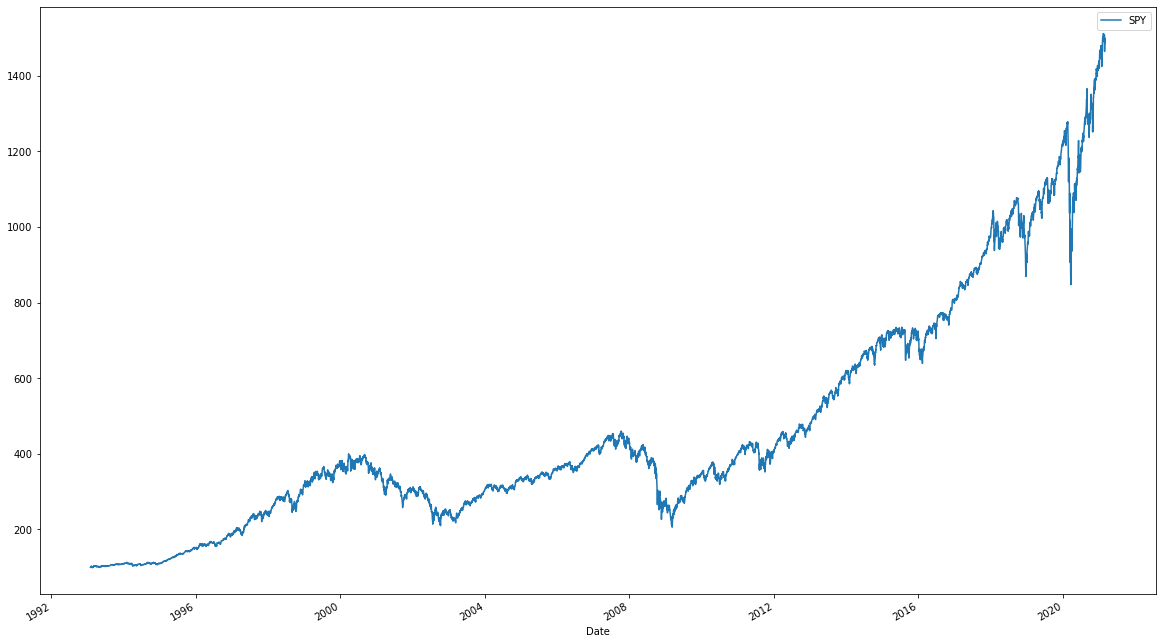

In [178]:
(combined_data / combined_data.iloc[0] * 100).plot(figsize=(20, 12))

In [179]:
combined_data['return'] = np.log(combined_data / combined_data.shift(1))
combined_data['direction'] = np.where(combined_data['return'] > 0, 1, 0)
combined_data.dropna(inplace=True)
combined_data.head()

,SPY,return,direction
Date,,,
1993-02-01,26.153660,0.007087,1
1993-02-02,26.209057,0.002116,1
1993-02-03,26.486113,0.010516,1
1993-02-04,26.596937,0.004176,1
1993-02-05,26.578478,-0.000694,0


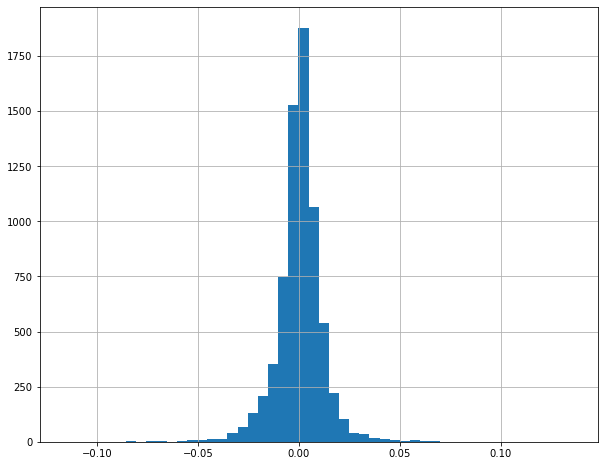

In [180]:
combined_data['return'].hist(bins=50, figsize=(10, 8));

# Feature Engineering

In [181]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    combined_data[col] = combined_data['return'].shift(lag)
    cols.append(col)
combined_data.dropna(inplace=True)

In [182]:
import ta
from ta.volatility import BollingerBands

In [183]:
indicator_bb = BollingerBands(close=combined_data['SPY'], window=20, window_dev=2)
combined_data['bb_bbm'] = indicator_bb.bollinger_mavg()
combined_data['bb_bbh'] = indicator_bb.bollinger_hband()
combined_data['bb_bbl'] = indicator_bb.bollinger_lband()

In [184]:
from ta.trend import MACD

In [185]:
indicator_macd = MACD(close = combined_data['SPY'], window_slow = 26, window_fast = 12, window_sign = 9, fillna = False)
combined_data['macd'] = indicator_macd.macd()
combined_data['macd_diff'] = indicator_macd.macd_diff()
combined_data['macd_signal'] = indicator_macd.macd_signal()

In [186]:
combined_data['momentum'] = combined_data['return'].rolling(5).mean().shift(1)
combined_data['volatility'] = combined_data['return'].rolling(20).std().shift(1)
combined_data['distance'] = (combined_data[stock] - combined_data[stock].rolling(50).mean()).shift(1)

In [187]:
combined_data.dropna(inplace=True)
combined_data

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm,bb_bbh,bb_bbl,macd,macd_diff,macd_signal,momentum,volatility,distance
Date,,,,,,,,,,,,,,,,,
1993-04-21,26.425627,-0.000703,0,-0.004900,-0.004181,0.000000,0.000000,-0.001390,26.579659,26.994298,26.165021,-0.014692,-0.012912,-0.001780,-0.002094,0.006664,-0.044106
1993-04-22,26.091602,-0.012721,0,-0.000703,-0.004900,-0.004181,0.000000,0.000000,26.551824,27.016068,26.087579,-0.050116,-0.038669,-0.011447,-0.001957,0.006641,-0.059621
1993-04-23,25.980268,-0.004276,0,-0.012721,-0.000703,-0.004900,-0.004181,0.000000,26.510070,27.019968,26.000172,-0.086180,-0.059786,-0.026394,-0.004501,0.007186,-0.387602
1993-04-26,25.776127,-0.007889,0,-0.004276,-0.012721,-0.000703,-0.004900,-0.004181,26.465533,27.061250,25.869816,-0.129738,-0.082675,-0.047063,-0.005356,0.007006,-0.489927
1993-04-27,26.054495,0.010742,1,-0.007889,-0.004276,-0.012721,-0.000703,-0.004900,26.429346,27.032567,25.826125,-0.140180,-0.074494,-0.065686,-0.006098,0.007095,-0.678391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-24,391.769989,0.010959,1,0.001214,-0.007721,-0.001768,-0.004265,0.000229,386.078500,399.272681,372.884319,3.510671,-0.434931,3.945602,-0.002462,0.009920,9.025182
2021-02-25,382.329987,-0.024391,0,0.010959,0.001214,-0.007721,-0.001768,-0.004265,386.474500,398.682639,374.266360,2.722356,-0.978597,3.700953,-0.000316,0.010181,12.763240
2021-02-26,380.359985,-0.005166,0,-0.024391,0.010959,0.001214,-0.007721,-0.001768,386.610999,398.476772,374.745225,1.916554,-1.427519,3.344073,-0.004341,0.010134,2.971542


<AxesSubplot:xlabel='Date'>

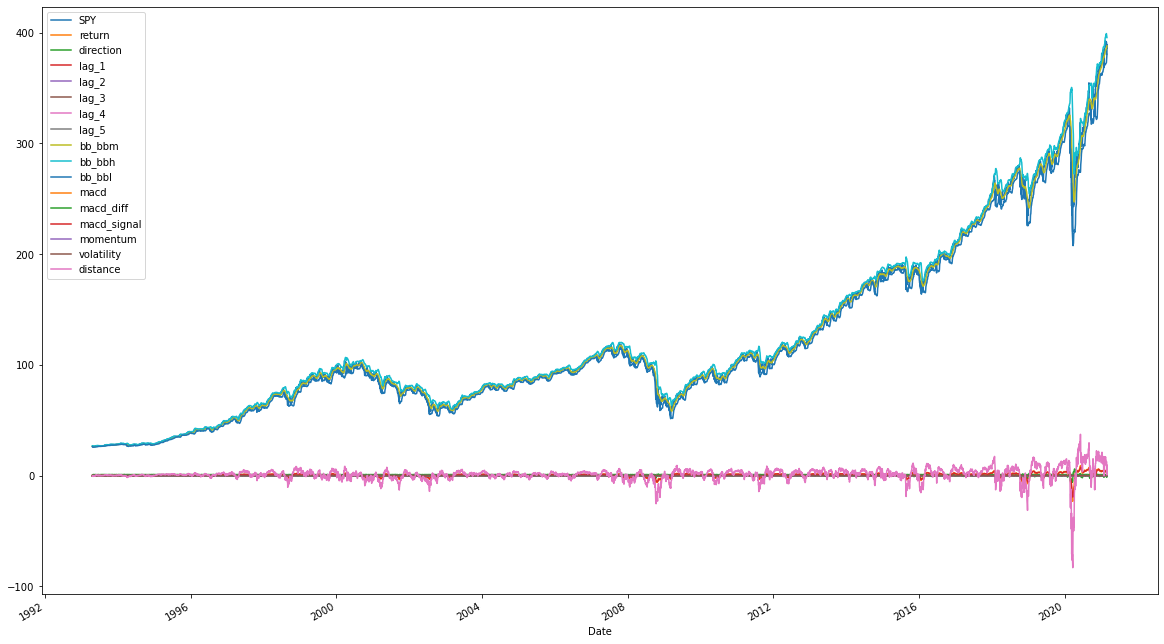

In [188]:
combined_data.plot(figsize=(20, 12))

In [189]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random

In [190]:
optimizer = Adam(learning_rate=0.0001)

In [191]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

In [192]:
metric = 'accuracy'

In [193]:
cols = list(combined_data.columns)

In [194]:
cols = cols[3:]
cols

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'bb_bbm',
 'bb_bbh',
 'bb_bbl',
 'macd',
 'macd_diff',
 'macd_signal',
 'momentum',
 'volatility',
 'distance']

In [195]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu',
        input_shape=(len(cols),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # <5>
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[metric])

In [196]:
cutoff = '2012-12-31'

In [197]:
combined_data['direction'] = np.where(combined_data['return'] > 0, 1, 0)
combined_data

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm,bb_bbh,bb_bbl,macd,macd_diff,macd_signal,momentum,volatility,distance
Date,,,,,,,,,,,,,,,,,
1993-04-21,26.425627,-0.000703,0,-0.004900,-0.004181,0.000000,0.000000,-0.001390,26.579659,26.994298,26.165021,-0.014692,-0.012912,-0.001780,-0.002094,0.006664,-0.044106
1993-04-22,26.091602,-0.012721,0,-0.000703,-0.004900,-0.004181,0.000000,0.000000,26.551824,27.016068,26.087579,-0.050116,-0.038669,-0.011447,-0.001957,0.006641,-0.059621
1993-04-23,25.980268,-0.004276,0,-0.012721,-0.000703,-0.004900,-0.004181,0.000000,26.510070,27.019968,26.000172,-0.086180,-0.059786,-0.026394,-0.004501,0.007186,-0.387602
1993-04-26,25.776127,-0.007889,0,-0.004276,-0.012721,-0.000703,-0.004900,-0.004181,26.465533,27.061250,25.869816,-0.129738,-0.082675,-0.047063,-0.005356,0.007006,-0.489927
1993-04-27,26.054495,0.010742,1,-0.007889,-0.004276,-0.012721,-0.000703,-0.004900,26.429346,27.032567,25.826125,-0.140180,-0.074494,-0.065686,-0.006098,0.007095,-0.678391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-24,391.769989,0.010959,1,0.001214,-0.007721,-0.001768,-0.004265,0.000229,386.078500,399.272681,372.884319,3.510671,-0.434931,3.945602,-0.002462,0.009920,9.025182
2021-02-25,382.329987,-0.024391,0,0.010959,0.001214,-0.007721,-0.001768,-0.004265,386.474500,398.682639,374.266360,2.722356,-0.978597,3.700953,-0.000316,0.010181,12.763240
2021-02-26,380.359985,-0.005166,0,-0.024391,0.010959,0.001214,-0.007721,-0.001768,386.610999,398.476772,374.745225,1.916554,-1.427519,3.344073,-0.004341,0.010134,2.971542


In [198]:
training_data = combined_data[combined_data.index < cutoff].copy()

In [199]:
mu, std = training_data.mean(), training_data.std()

In [200]:
training_data_ = (training_data - mu) / std
training_data_

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm,bb_bbh,bb_bbl,macd,macd_diff,macd_signal,momentum,volatility,distance
Date,,,,,,,,,,,,,,,,,
1993-04-21,-1.938030,-0.081053,-1.068995,-0.419008,-0.361109,-0.024627,-0.024677,-0.136692,-1.927179,-1.948975,-1.896559,-0.157025,-0.047030,-0.151750,-0.475592,-0.616988,-0.151621
1993-04-22,-1.950771,-1.048372,-1.068995,-0.081155,-0.418957,-0.361183,-0.024677,-0.024804,-1.928241,-1.948169,-1.899602,-0.194734,-0.137727,-0.162685,-0.448354,-0.620528,-0.156253
1993-04-23,-1.955017,-0.368686,-1.068995,-1.048535,-0.081108,-0.419031,-0.361235,-0.024804,-1.929836,-1.948025,-1.903036,-0.233124,-0.212088,-0.179592,-0.952411,-0.536976,-0.254184
1993-04-26,-1.962803,-0.659443,-1.068995,-0.368806,-1.048477,-0.081177,-0.419084,-0.361381,-1.931536,-1.946498,-1.908158,-0.279492,-0.292687,-0.202971,-1.121853,-0.564582,-0.284737
1993-04-27,-1.952186,0.840059,0.935270,-0.659582,-0.368756,-1.048560,-0.081228,-0.419233,-1.932918,-1.947559,-1.909875,-0.290607,-0.263879,-0.224037,-1.268759,-0.550986,-0.341009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-21,1.711984,-0.758445,-1.068995,0.437108,-0.624821,0.866214,0.915789,-0.324455,1.682006,1.616611,1.744940,0.708489,0.740224,0.515068,0.625111,-0.697508,0.726522
2012-12-24,1.697632,-0.272881,-1.068995,-0.758590,0.437149,-0.624898,0.866171,0.915715,1.685751,1.617680,1.751511,0.639876,0.410291,0.548143,0.411289,-0.721066,0.394515
2012-12-26,1.678061,-0.364459,-1.068995,-0.272996,-0.758535,0.437086,-0.624953,0.866094,1.689683,1.613795,1.763730,0.533642,0.046789,0.552026,-0.173953,-0.716613,0.281761


In [201]:
test_data = combined_data[combined_data.index >= cutoff].copy()

In [202]:
test_data_ = (test_data - mu) / std

In [203]:
%%time
model.fit(training_data[cols],
          training_data['direction'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False)

Wall time: 6.36 s


In [204]:
res = pd.DataFrame(model.history.history)

In [205]:
res.head()

,loss,accuracy,val_loss,val_accuracy
0,1.378863,0.505544,0.699004,0.517623
1,0.696738,0.523942,0.702652,0.477341
2,0.695721,0.526966,0.714481,0.454179
3,0.695572,0.516129,0.725558,0.446123
4,0.695606,0.510081,0.737882,0.443102


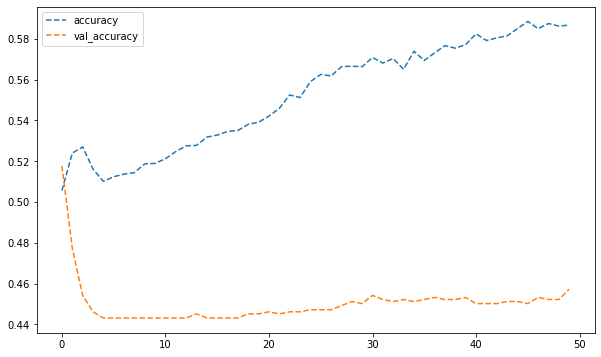

In [206]:
res[[metric, 'val_' + metric]].plot(figsize=(10, 6), style='--');

In [207]:
model.evaluate(training_data_[cols], training_data['direction'])

156/156 [==============================] - 0s 456us/step - loss: 0.7101 - accuracy: 0.5070


[0.7101361155509949, 0.5069542527198792]

In [208]:
pred = np.where(model.predict(training_data_[cols]) > 0.5,1,0)

In [209]:
pred[:30].flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [210]:
training_data['prediction'] = np.where(pred > 0, 1, -1)

In [211]:
training_data['strategy'] = (training_data['prediction'] *
                            training_data['return'])

In [212]:
training_data[['return', 'strategy']].sum().apply(np.exp)

return       4.528864
strategy    43.593116
dtype: float64

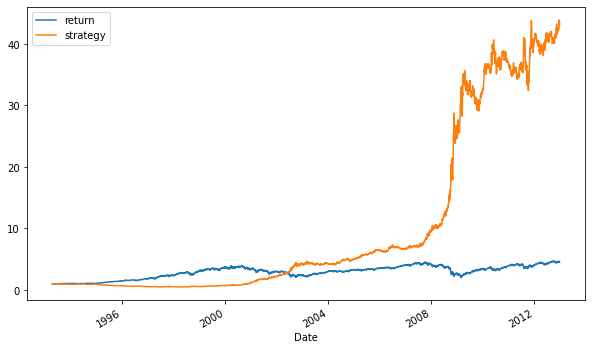

In [213]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

In [214]:
model.evaluate(test_data_[cols], test_data['direction'])

65/65 [==============================] - 0s 470us/step - loss: 0.8184 - accuracy: 0.5506


[0.8184014558792114, 0.5505836606025696]

In [215]:
cols

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'bb_bbm',
 'bb_bbh',
 'bb_bbl',
 'macd',
 'macd_diff',
 'macd_signal',
 'momentum',
 'volatility',
 'distance']

In [216]:
pred = np.where(model.predict(test_data_[cols]) > 0.5,1,0)

In [217]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [218]:
test_data['prediction'].value_counts()

-1    1235
 1     821
Name: prediction, dtype: int64

In [219]:
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])

In [220]:
test_data[['return', 'strategy']].sum().apply(np.exp)

return       3.227564
strategy    10.021410
dtype: float64

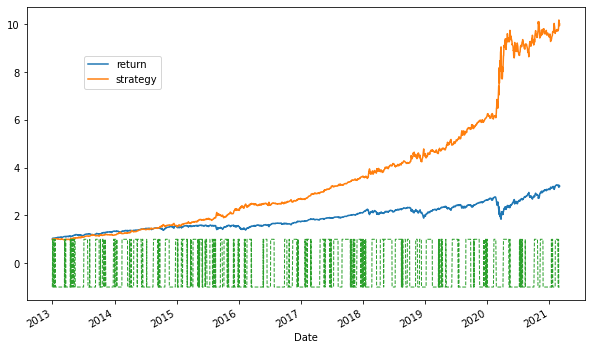

In [221]:
ax = test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
test_data['prediction'].plot(ax = ax, lw=1, secondary_y = 'Position', style = '--')
ax.get_legend().set_bbox_to_anchor((0.25,0.85));

In [222]:
combined_data[combined_data.index >= cutoff]['direction']

Date
2012-12-31    1
2013-01-02    1
2013-01-03    0
2013-01-04    1
2013-01-07    0
             ..
2021-02-24    1
2021-02-25    0
2021-02-26    0
2021-03-01    1
2021-03-02    0
Name: direction, Length: 2056, dtype: int32

In [249]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
report = classification_report(combined_data[combined_data.index >= cutoff]['direction'], pred)
print(report)
print("Confusion Matrix")
print(confusion_matrix(combined_data[combined_data.index >= cutoff]['direction'], pred))

print('')
print("Accuracy")
print(accuracy_score(combined_data[combined_data.index >= cutoff]['direction'], pred))

              precision    recall  f1-score   support

           0       0.49      0.67      0.57       907
           1       0.64      0.46      0.53      1149

    accuracy                           0.55      2056
   macro avg       0.57      0.56      0.55      2056
weighted avg       0.57      0.55      0.55      2056

Confusion Matrix
[[609 298]
 [626 523]]

Accuracy
0.5505836575875487


In [235]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [246]:
y_pred_keras = pred.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_data['direction'], y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

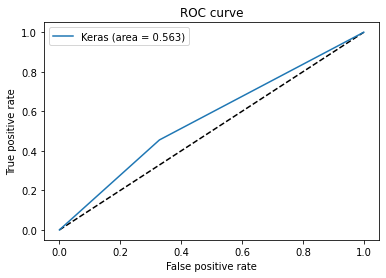

In [247]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [250]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


Start date,2013-01-02
End date,2021-03-02
Total months,97
,Backtest
Annual return,31.063%
Cumulative returns,807.867%
Annual volatility,16.817%
Sharpe ratio,1.69
Calmar ratio,2.02
Stability,0.99
Max drawdown,-15.364%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.36,2020-03-23,2020-03-30,2020-04-14,17
1,11.95,2020-05-14,2020-06-08,2020-10-28,120
2,10.74,2015-08-25,2015-10-05,2015-11-13,59
3,8.82,2018-10-29,2018-12-12,2018-12-24,41
4,8.41,2020-10-30,2021-01-08,2021-02-26,86


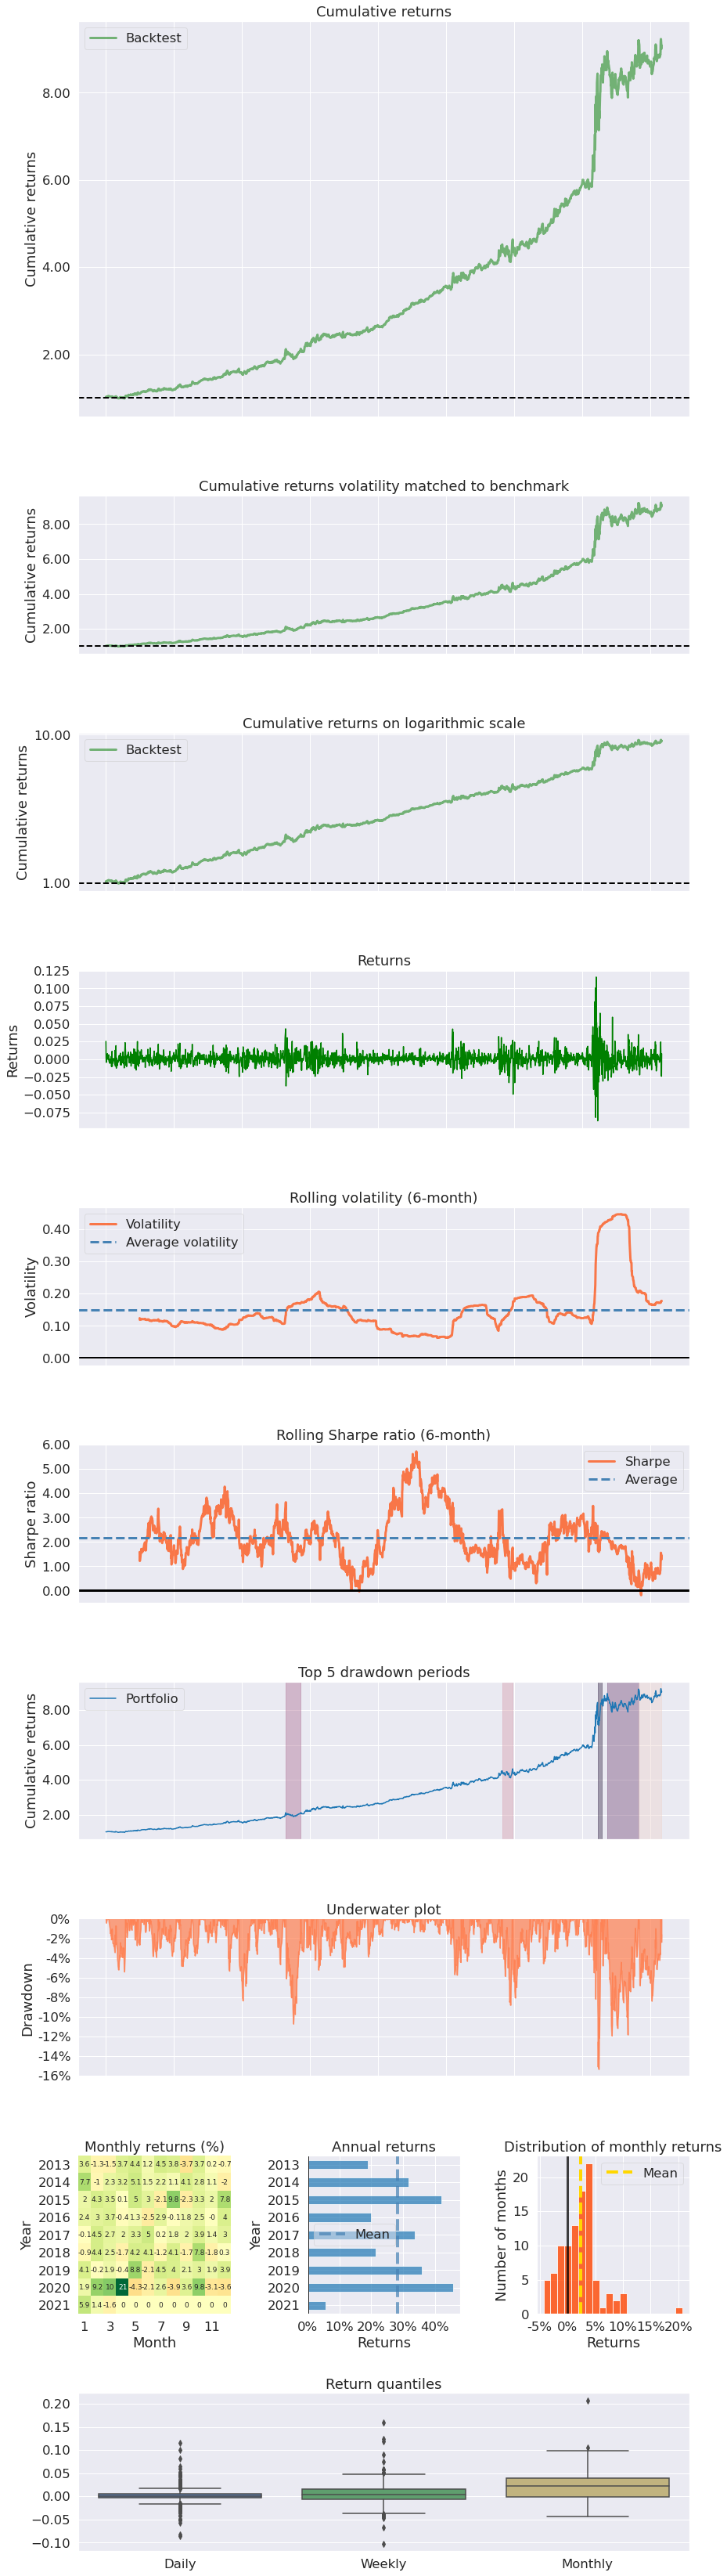

In [254]:
meta_returns = test_data['strategy'].loc['20130102':]
pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None)